# Reseach Topic: Predict Wage with Machline Methods
## What am I doing ?
For now, we predict salary with several models.

## Data
The source of data is NLSY97. The portal can be accessed from [here](https://www.nlsinfo.org/investigator/pages/search.jsp?s=NLSY97). The data set is pre-cleaned by STATA with around 4500 obervations each year from 2. Features include age, year of experience, gender, schooling, race, marital status, industry, region(not yet!!). 

## Run Some Models
Bofore running anything, we split the data into training set, validation set, test set. <br/> I am preparing to do the following models:
- Linear model (Panel Data Regression)
- Trees and Forests (Regression Trees, Random Forests and XGBoost)
- Neural Nets (Multilayer Perceptrons)

The performences of models will be compared in accuracy and R-square

## Further Thoughts
(Haven't done yet) We resample the data into previous years and the following years. Then we train the model on previous years data and test it on the data from the following years.

# Let's get started :D

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

'''
Read in Data
'''
data_path = './data/mincer.xlsx'
dat = pd.read_excel(data_path)
dat = dat.fillna(0)

In [2]:
global train
years = [i for i in range(2005,2011)]+[2013]+[2015]
dat_tmp = dat 
train, test =  train_test_split(dat_tmp, test_size = 0.2, random_state = 12)
y_train, X_train, y_test, X_test = train['lnwage'], train.iloc[:,4:], test['lnwage'], test.iloc[:,4:]

In [3]:
dat.keys()

Index(['wage', 'lnwage', 'race', 'industry', 'id', 'sex', 'schooling', 'year',
       'marital_status', 'age', 'exp', 'exp2', 'exp3', 'race_1', 'race_2',
       'race_3', 'industry_1', 'industry_2', 'industry_3', 'industry_4',
       'industry_5', 'industry_6', 'industry_7', 'industry_8', 'industry_9',
       'industry_10', 'industry_11', 'industry_12', 'industry_13',
       'industry_14', 'industry_15', 'industry_16', 'industry_18'],
      dtype='object')

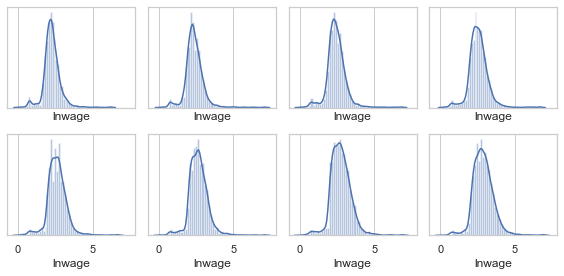

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
f, axes = plt.subplots(2, 4, figsize=(8, 4), sharex=True)

i,j = 0,0
for y in years:
    sns.distplot(dat[dat['year']==y]['lnwage'], ax = axes[j,i])
    if i < 3:
        i += 1
    else:
        i,j = 0,1 
plt.setp(axes, yticks=[])
plt.tight_layout()

## Define Models here

In [4]:
import numpy as np 
import pandas as pd 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.optimizers import adam

def mincer(X_train, y_train,  X_test, y_test):
    regressor = LinearRegression()
    reg = regressor.fit(X_train,y_train)
    return evaluate(reg, X_train, X_test, y_train, y_test)

def trees(X_train, y_train, X_test, y_test, model="rf",max_depth=15):
    if  model == "gb":
        regressor = GradientBoostingRegressor(max_depth=5)
    else:
        regressor = RandomForestRegressor(max_depth, random_state=1)
    reg = regressor.fit(X_train, y_train)
    return evaluate(reg, X_train, X_test, y_train, y_test)


def tree(X_train, y_train, X_test, y_test):
    regressor = DecisionTreeRegressor()
    reg = regressor.fit(X_train, y_train)
    return evaluate(reg, X_train, X_test, y_train, y_test)

def nn(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Dense(128, input_dim=26, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    # model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    # model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    history = model.fit(X_train, y_train, epochs=10, batch_size = 50,  verbose=1, validation_split=0.10)
    
    return evaluate(model, X_train, X_test, y_train, y_test)

def evaluate(model, X_train, X_test, y_train, y_test):
    y_pred_in = np.array( model.predict(X_train) )
    y_pred_out = np.array( model.predict(X_test) )
    if y_pred_in.ndim >1:
        y_pred_in = y_pred_in.flatten()
        y_pred_out =  y_pred_out.flatten()

    r2_in = metrics.r2_score(y_train,y_pred_in)
    r2_out = metrics.r2_score(y_test,y_pred_out)
    mse_in = np.mean((y_pred_in - np.array(y_train))**2)
    mse_out = np.mean((y_pred_out - np.array( y_test) )**2 )

    return mse_in, mse_out, r2_in, r2_out

Using TensorFlow backend.


# Test 1: Comparasion Between the Models

## Tree

## Random Forest

## XGBoost

## Overall comparation Run 4 models and take the averges

In [241]:
iters = 5
res_linear, res_tree, res_rf, res_xgb, res_nn = np.array([0.0]*4),np.array([0.0]*4),np.array([0.0]*4),np.array([0.0]*4),np.array([0.0]*4)
for i in range(iters):
    print("foler:{}".format(i+1))
    res_linear += np.array(mincer(X_train, y_train, X_test, y_test) )

    res_tree += np.array( tree(X_train, y_train, X_test, y_test) )

    res_rf += np.array( trees(X_train, y_train, X_test, y_test ) )

    res_xgb += np.array( trees(X_train, y_train, X_test, y_test,model = "gb",max_depth=12) )

    res_nn += np.array( nn(X_train, y_train, X_test, y_test) )

tab1 = "Regression & "+" & ".join([str(round(num,5)) for num in res_linear/iters ]) + r" \\" + "\n" 
tab2 = "Regression Tree & "+" & ".join([str(round(num,5)) for num in res_tree/iters ]) + r" \\" + "\n"
tab3 = "Random Forest & "+" & ".join([str(round(num,5)) for num in res_rf/iters]) +r" \\" +  "\n"
tab4 = "XGBoost & "+" & ".join([str(round(num,5)) for num in res_xgb/iters]) + r" \\" + "\n"
tab5 = "Neural Networks & "+" & ".join([str(round(num,5)) for num in res_nn/iters]) + r" \\" + "\n"
print( tab1+ tab2+ tab3+ tab4+ tab5)

foler:1
Train on 30260 samples, validate on 3363 samples
Epoch 1/10
30260/30260 [==============================] - 1s 26us/step - loss: 1.1049 - mean_absolute_error: 1.1049 - val_loss: 0.5849 - val_mean_absolute_error: 0.5849
Epoch 2/10
30260/30260 [==============================] - 1s 19us/step - loss: 0.6312 - mean_absolute_error: 0.6312 - val_loss: 0.5716 - val_mean_absolute_error: 0.5716
Epoch 3/10
30260/30260 [==============================] - 1s 21us/step - loss: 0.5365 - mean_absolute_error: 0.5365 - val_loss: 0.4645 - val_mean_absolute_error: 0.4645
Epoch 4/10
30260/30260 [==============================] - 1s 20us/step - loss: 0.5052 - mean_absolute_error: 0.5052 - val_loss: 0.6499 - val_mean_absolute_error: 0.6499
Epoch 5/10
30260/30260 [==============================] - 1s 21us/step - loss: 0.4721 - mean_absolute_error: 0.4721 - val_loss: 0.5962 - val_mean_absolute_error: 0.5962
Epoch 6/10
30260/30260 [==============================] - 1s 20us/step - loss: 0.4441 - mean_absol

# Test 2: Performance Over the Years
Now I am running the models over the years (2005 to 2011, 2013, 2015). 

In [146]:
years = [i for i in range(2005,2011)]+[2013]+[2015]
res={}
res['ols'],res['trees'], res['nets'] = [],[],[]
for y in years:
    print("---------current test year is {}---------".format(y) )
    data = dat[dat['year']==y]
    train, test =  train_test_split(data, test_size = 0.25, random_state = 12)
    y_train, X_train, y_test, X_test = train['lnwage'], train.iloc[:,4:], test['lnwage'], test.iloc[:,4:]
    res['ols'].append( mincer(X_train, y_train,  X_test, y_test) )
    res['trees'].append( trees(X_train, y_train, X_test, y_test, n_estimators=50, max_depth=5) )
    res['nets'].append(nn(X_train, y_train, X_test, y_test))
    

---------current test year is 2005---------


TypeError: trees() got an unexpected keyword argument 'n_estimators'

In [0]:
import matplotlib.pyplot as plt

plt.plot(years, res['ols'], label = "Mincer")
plt.plot(years, res['trees'], label = "Random Forest")
plt.plot(years, res['nets'], label = "Neural Nets")
plt.ylabel(r'$R^2$')
plt.xlabel('year')
plt.title(r'Test $R^2$ Over Years')
plt.legend()
plt.show()